<ipython-input-3-5acc4ee6477d>:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if latest_year_data[i]/total > 0.05:  # Only add text for slices > 5%
<ipython-input-3-5acc4ee6477d>:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax4.text(x*0.7, y*0.7, f"{latest_year_data[i]/total:.1%}",


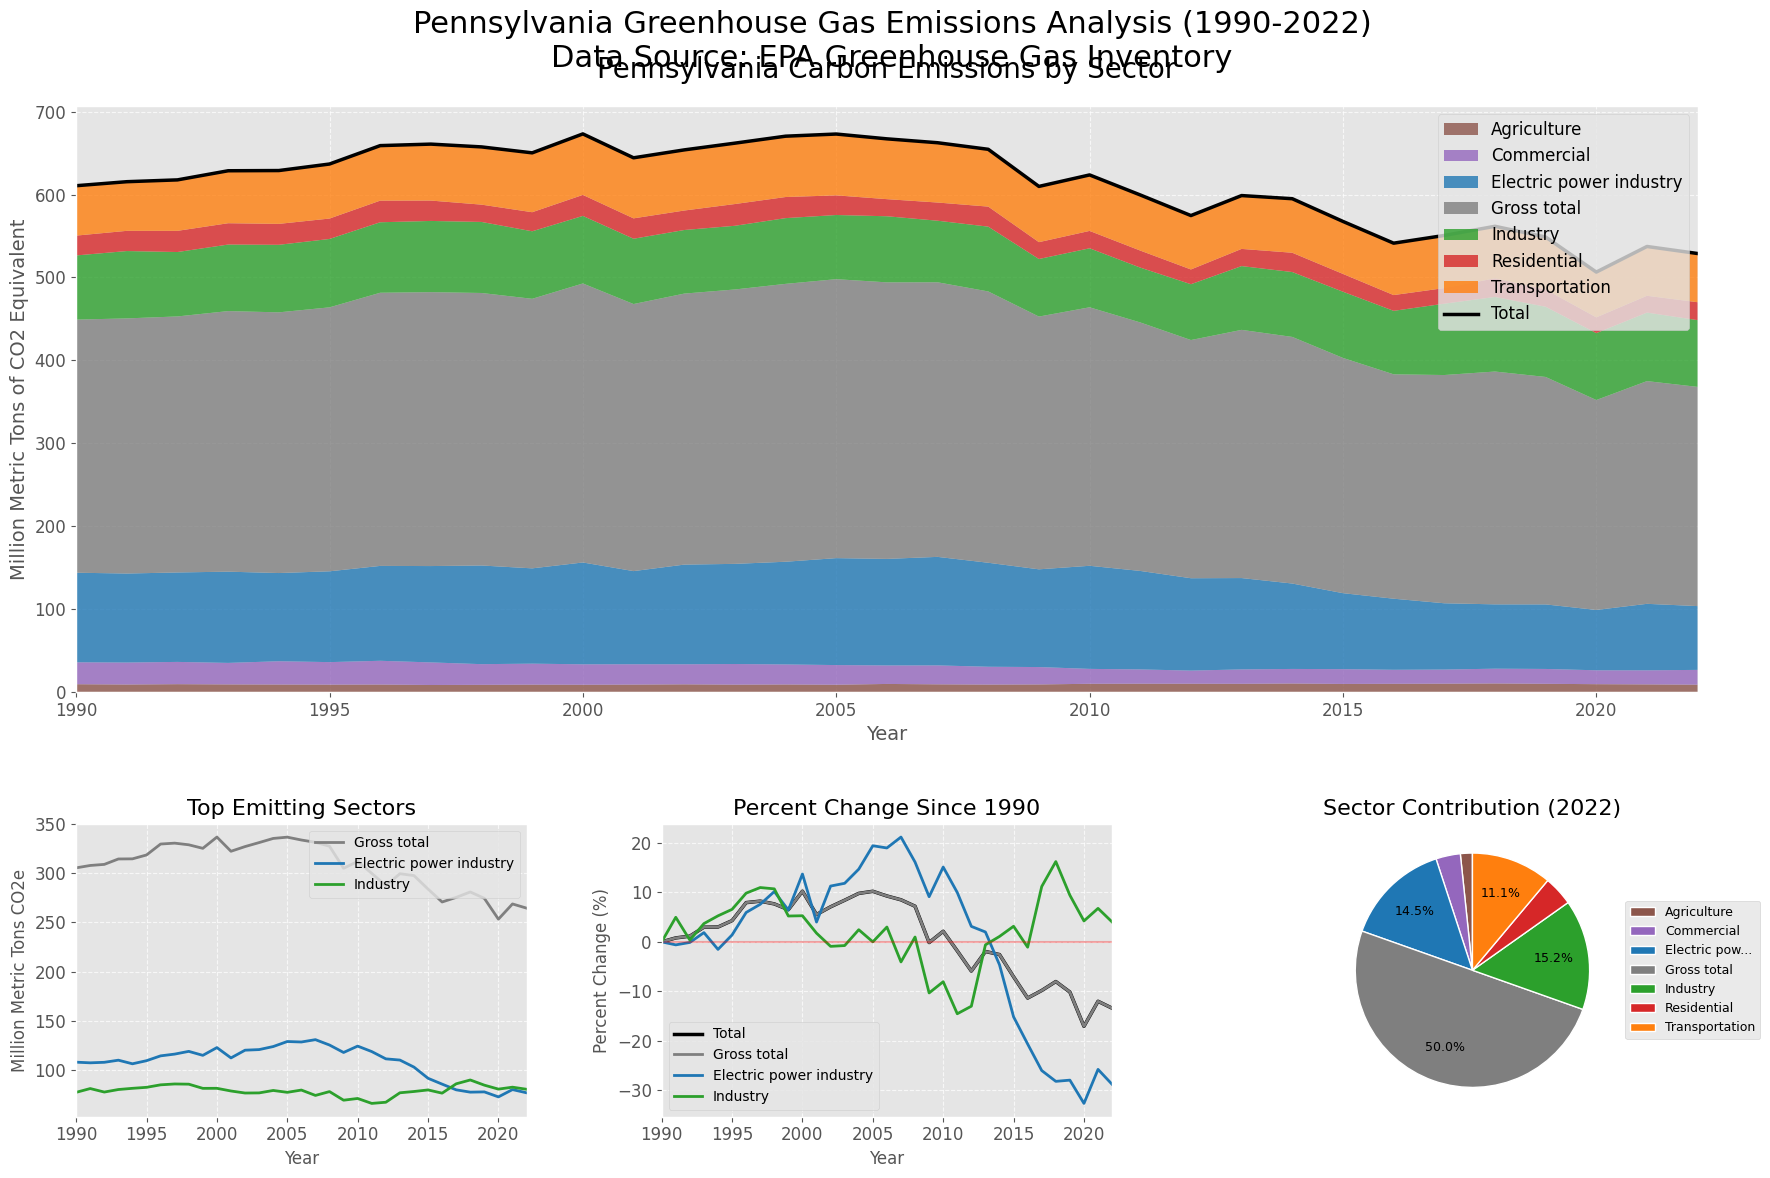

In [3]:
# Pennsylvania Carbon Emissions Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set the style
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})

def process_epa_ghg_data(filename):
    data = pd.read_csv(filename)
    
    # Rename the first column
    data = data.rename(columns={data.columns[0]: 'Sector'})
    
    # Get the list of year
    years = [int(col) for col in data.columns[1:] if col.isdigit()]
    
    long_data = pd.melt(
        data, 
        id_vars=['Sector'],
        value_vars=[str(year) for year in years],
        var_name='Year',
        value_name='Emissions'
    )
    
    long_data['Year'] = long_data['Year'].astype(int)
    
    long_data['Emissions'] = pd.to_numeric(long_data['Emissions'], errors='coerce')
    
    # Create a pivot table
    pivot_data = long_data.pivot(index='Year', columns='Sector', values='Emissions').reset_index()
    
    pivot_data['Total'] = pivot_data.drop(columns=['Year']).sum(axis=1)
    
    # Calculate percent change from first year 
    baseline_year = pivot_data['Year'].min()
    sectors = [col for col in pivot_data.columns if col not in ['Year', 'Total']]
    
    for sector in sectors + ['Total']:
        baseline_value = pivot_data.loc[pivot_data['Year'] == baseline_year, sector].values[0]
        pivot_data[f'{sector}_pct_change'] = ((pivot_data[sector] / baseline_value) - 1) * 100
    
    return pivot_data

def create_emissions_visualization(ghg_data, output_filename=None):
    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(2, 3, figure=fig, height_ratios=[2, 1])
    
    sector_colors = {
        'Transportation': '#ff7f0e',  
        'Industry': '#2ca02c',        
        'Electric Power': '#1f77b4',     
        'Commercial': '#9467bd',         
        'Residential': '#d62728',        
        'Agriculture': '#8c564b',        
        'U.S. Territories': '#e377c2',   
        'Industrial': '#2ca02c',         
        'Transportation and mobile sources': '#ff7f0e', 
        'Electric power industry': '#1f77b4',      
        'Commercial and residential': '#d62728',      
        'Agriculture, forestry, and land use': '#8c564b',
        'Gross total': '#7f7f7f'   
        }
    # Extract years and get sectors
    years = ghg_data['Year'].values
    sectors = [col for col in ghg_data.columns if col not in ['Year', 'Total'] 
              and not col.endswith('_pct_change')]
    
    # Get colors for each sector
    colors = [sector_colors.get(sector, '#7f7f7f') for sector in sectors]
    
    # Main plot
    ax1 = fig.add_subplot(gs[0, :])
    sector_data = [ghg_data[sector].values for sector in sectors]
    
    ax1.stackplot(years, sector_data, labels=sectors, colors=colors, alpha=0.8)
    ax1.plot(years, ghg_data['Total'], 'k-', linewidth=2.5, label='Total')
    
    # Customize main plot
    ax1.set_title('Pennsylvania Carbon Emissions by Sector', fontsize=20, pad=20)
    ax1.set_xlabel('Year', fontsize=14)
    ax1.set_ylabel('Million Metric Tons of CO2 Equivalent', fontsize=14)
    ax1.set_xlim(min(years), max(years))
    ax1.legend(loc='upper right', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Panel 1
    ax2 = fig.add_subplot(gs[1, 0])
    
    # Get top 3 sectors by average emissions
    top_sectors = ghg_data[sectors].mean().sort_values(ascending=False).index[:3]
    
    for sector in top_sectors:
        ax2.plot(years, ghg_data[sector], color=sector_colors.get(sector, '#7f7f7f'), 
                linewidth=2, label=sector)
    
    ax2.set_title('Top Emitting Sectors', fontsize=16)
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Million Metric Tons CO2e', fontsize=12)
    ax2.set_xlim(min(years), max(years))
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    #Panel 2: Percent change from baseline year
    ax3 = fig.add_subplot(gs[1, 1])
    
    baseline_year = min(years)
    
    ax3.plot(years, ghg_data['Total_pct_change'], 'k-', linewidth=2.5, label='Total')
    
    for sector in top_sectors:
        ax3.plot(years, ghg_data[f'{sector}_pct_change'], 
                color=sector_colors.get(sector, '#7f7f7f'), 
                linewidth=2, label=sector)
    
    ax3.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    ax3.set_title(f'Percent Change Since {baseline_year}', fontsize=16)
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylabel('Percent Change (%)', fontsize=12)
    ax3.set_xlim(min(years), max(years))
    ax3.legend(loc='lower left', fontsize=10)
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    #Panel 3: Pie chart of emissions by sector for latest year
    ax4 = fig.add_subplot(gs[1, 2])
    
    # Get the latest year data
    latest_year = max(years)
    latest_year_data = ghg_data.loc[ghg_data['Year'] == latest_year, sectors].iloc[0]
    
    pie_labels = [s[:12] + '...' if len(s) > 15 else s for s in sectors]
    
    wedges, texts = ax4.pie(
        latest_year_data, 
        labels=None,  # No direct labels
        colors=[sector_colors.get(sector, '#7f7f7f') for sector in sectors],
        startangle=90, 
        wedgeprops={'edgecolor': 'w', 'linewidth': 1}
    )
    
    # Add a legend
    ax4.legend(wedges, pie_labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)
    
    total = sum(latest_year_data)
    for i, wedge in enumerate(wedges):
        ang = (wedge.theta2 - wedge.theta1) / 2. + wedge.theta1
        if latest_year_data[i]/total > 0.05:  # Only add text for slices > 5%
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            ax4.text(x*0.7, y*0.7, f"{latest_year_data[i]/total:.1%}", 
                    ha='center', va='center', fontsize=9)
    
    ax4.set_title(f'Sector Contribution ({latest_year})', fontsize=16)
    
    # Adjust layout and add title
    plt.tight_layout()
    title_text = (f'Pennsylvania Greenhouse Gas Emissions Analysis ({min(years)}-{max(years)})\n'
                 f'Data Source: EPA Greenhouse Gas Inventory')
    fig.suptitle(title_text, fontsize=22, y=0.98)
    plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.3)
    
    # Save figure
    if output_filename:
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    
    return fig

filename = 'data.csv'
ghg_data = process_epa_ghg_data(filename)
fig = create_emissions_visualization(ghg_data, "pennsylvania_ghg_emissions.png")
plt.show()